In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [3]:
tweets = pd.read_excel('1May_to_1Jun_Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-05-10 23:59:46+00:00,1524177405614693888,JoGray39345857,1469035091842286080,NaN,NaN,0,#AmberTurd part 2 from stripper to Shitter! Lo...
1,1,2022-05-10 23:59:36+00:00,1524177364803997952,LynnSinclair15,1116186634133750016,NaN,NaN,2,Sitting here with my nieces and ulla \nthe con...
2,2,2022-05-10 23:59:08+00:00,1524177246591885056,FilmSchoolRooki,1093609176482365056,NaN,NaN,1,Look at #AmberHeard simp Mr Road Kill 🙄 dude p...
3,3,2022-05-10 23:58:55+00:00,1524177193714213120,TiffMCarter,201838819,NaN,NaN,0,At this point it doesn't matter if #Amberheard...
4,4,2022-05-10 23:58:54+00:00,1524177187829686016,DesperateGossip,25446454,NaN,NaN,0,"Johnny Depp and Amber Heard Trial: No Winners,..."


In [4]:
df = tweets.filter(['full_text', "created_at"], axis=1)
df_jan = df[(df['created_at'] > '2022-05-15') & (df['created_at'] < '2022-06-02')]
df2 = df_jan.dropna()
df2.head()

,full_text,created_at
25000,As a woman who has survived domestic violence ...,2022-05-15 23:59:50+00:00
25001,@DiscussingFilm Let Disney cast Amber Heard in...,2022-05-15 23:59:34+00:00
25002,@akimenziez @TetrisphereJon7 @SELI_TALE @TinaC...,2022-05-15 23:59:28+00:00
25003,Is it bad I’m excited that the Johnny Depp/ Am...,2022-05-15 23:59:25+00:00
25004,The fact that Boylan is siding with Amber Hear...,2022-05-15 23:59:06+00:00


# Data cleaning

In [5]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [6]:
df2.head()

,full_text,created_at,clean_text
25000,As a woman who has survived domestic violence ...,2022-05-15 23:59:50+00:00,"[woman, survived, domestic, violence, past, am..."
25001,@DiscussingFilm Let Disney cast Amber Heard in...,2022-05-15 23:59:34+00:00,"[let, disney, cast, instead, ensure, colossal,..."
25002,@akimenziez @TetrisphereJon7 @SELI_TALE @TinaC...,2022-05-15 23:59:28+00:00,"[like, said, date, irrelevant, post, picture, ..."
25003,Is it bad I’m excited that the Johnny Depp/ Am...,2022-05-15 23:59:25+00:00,"[bad, excited, trial, back, tomorrow]"
25004,The fact that Boylan is siding with Amber Hear...,2022-05-15 23:59:06+00:00,"[fact, boylan, siding, tells, everything, resp..."


In [7]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
25000,As a woman who has survived domestic violence ...,2022-05-15 23:59:50+00:00,"[woman, violence, woman, liar, lying, violence..."
25001,@DiscussingFilm Let Disney cast Amber Heard in...,2022-05-15 23:59:34+00:00,[disney]
25002,@akimenziez @TetrisphereJon7 @SELI_TALE @TinaC...,2022-05-15 23:59:28+00:00,"[date, post, picture, photograph, proof, date,..."
25003,Is it bad I’m excited that the Johnny Depp/ Am...,2022-05-15 23:59:25+00:00,"[trial, tomorrow]"
25004,The fact that Boylan is siding with Amber Hear...,2022-05-15 23:59:06+00:00,"[fact, boylan, siding, respect, fruit, bird]"


In [8]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


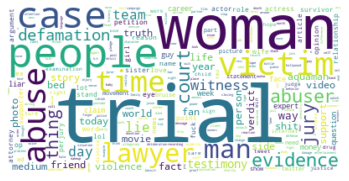

In [9]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

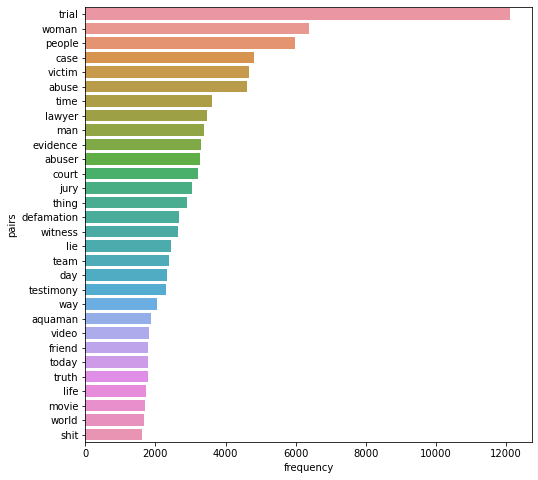

In [10]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [11]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['woman', 'violence', 'woman', 'liar', 'lying', 'violence', 'people'], ['disney'], ['date', 'post', 'picture', 'photograph', 'proof', 'date', 'time', 'post', 'stuff', 'time', 'cross', 'year']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'liar'), (1, 'lying'), (2, 'people'), (3, 'violence'), (4, 'woman'), (5, 'disney'), (6, 'cross'), (7, 'date'), (8, 'photograph'), (9, 'picture'), (10, 'post'), (11, 'proof'), (12, 'stuff'), (13, 'time'), (14, 'year'), (15, 'tomorrow'), (16, 'trial'), (17, 'bird'), (18, 'boylan'), (19, 'fact'), (20, 'fruit'), (21, 'respect'), (22, 'siding'), (23, 'animal'), (24, 'cruelty'), (25, 'dog'), (26, 'record'), (27, 'ring'), (28, 'flight'), (29, 'friend'), (30, 'moss'), (31, 'stair'), (32, 'blame'), (33, 'family'), (34, 'mean'), (35, 'spector'), (36, 'text'), (37, 'abuser'), (38, 'action'), (39, 'medium'), (40, 'moment'), (41, 'prop'), (42, 'difference'), (43, 'career'), (44, 'crisis'), (45, 'expert'), (46, 'v'), (47, 'l'), (48, 'life'), (49, 'oreal')]

Total Vocabulary Size: 7496


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [14]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [15]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3186090612052463
Perplexity Score:  -6.901408497444296

topic number:  3
Coherence Score:  0.32396789370677387
Perplexity Score:  -6.964007023737986

topic number:  4
Coherence Score:  0.3679763887043811
Perplexity Score:  -7.0141658284809925

topic number:  5
Coherence Score:  0.36818871340576326
Perplexity Score:  -7.066794408375642

topic number:  6
Coherence Score:  0.2988835736901328
Perplexity Score:  -7.078771687349561

topic number:  7
Coherence Score:  0.32489947640231787
Perplexity Score:  -7.101622088398796

topic number:  8
Coherence Score:  0.3389068533192311
Perplexity Score:  -7.135865725804692

topic number:  9
Coherence Score:  0.32553031683907935
Perplexity Score:  -7.200253308359114

topic number:  10
Coherence Score:  0.2859710697665284
Perplexity Score:  -7.366410894557859

topic number:  11
Coherence Score:  0.2925092050327592
Perplexity Score:  -7.629406866207885

topic number:  12
Coherence Score:  0.2969724487775216
Perplexi

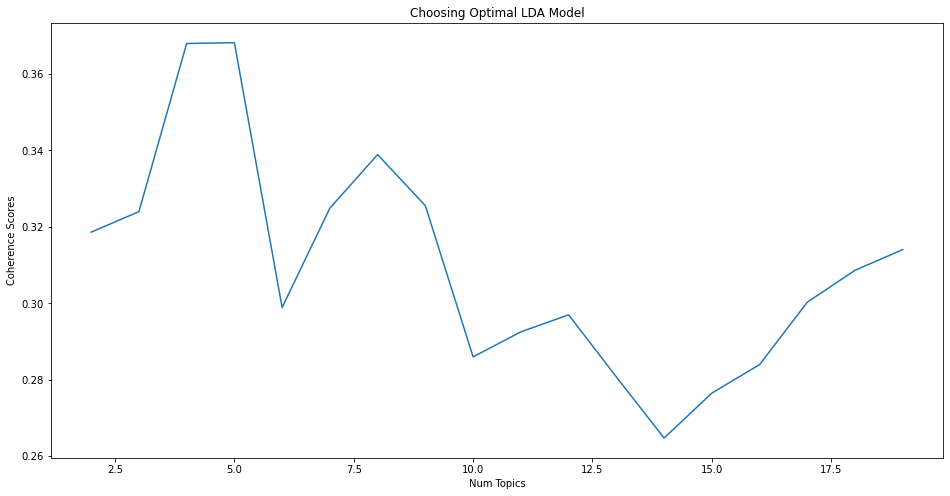

In [16]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [17]:
ntopics_des_name = 5

# We choose 5 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [18]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.066*"victim" + 0.062*"abuse" + 0.039*"case" + 0.034*"abuser" + '
  '0.031*"evidence" + 0.022*"woman" + 0.022*"violence" + 0.019*"people" + '
  '0.017*"survivor" + 0.016*"story"'),
 (1,
  '0.042*"time" + 0.035*"team" + 0.034*"witness" + 0.021*"friend" + '
  '0.020*"money" + 0.015*"lol" + 0.013*"court" + 0.011*"actress" + 0.011*"win" '
  '+ 0.010*"picture"'),
 (2,
  '0.032*"video" + 0.031*"verdict" + 0.028*"photo" + 0.025*"shit" + '
  '0.019*"bed" + 0.019*"guy" + 0.018*"career" + 0.017*"question" + 0.015*"tmz" '
  '+ 0.014*"internet"'),
 (3,
  '0.166*"trial" + 0.045*"jury" + 0.041*"lawyer" + 0.037*"defamation" + '
  '0.026*"case" + 0.025*"testimony" + 0.024*"court" + 0.019*"day" + '
  '0.016*"argument" + 0.016*"week"'),
 (4,
  '0.053*"woman" + 0.050*"people" + 0.030*"man" + 0.023*"thing" + 0.022*"lie" '
  '+ 0.021*"truth" + 0.020*"support" + 0.019*"fan" + 0.014*"medium" + '
  '0.013*"life"')]


In [19]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [20]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [21]:
df2['Topic'] = topic_num

In [22]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
25000,As a woman who has survived domestic violence ...,"[woman, violence, woman, liar, lying, violence...","[4, 0, 2, 1, 3]"
25001,@DiscussingFilm Let Disney cast Amber Heard in...,[disney],"[1, 2, 0, 3, 4]"
25002,@akimenziez @TetrisphereJon7 @SELI_TALE @TinaC...,"[date, post, picture, photograph, proof, date,...","[1, 0, 2, 4, 3]"
25003,Is it bad I’m excited that the Johnny Depp/ Am...,"[trial, tomorrow]","[3, 1, 2, 0, 4]"
25004,The fact that Boylan is siding with Amber Hear...,"[fact, boylan, siding, respect, fruit, bird]","[4, 0, 2, 1, 3]"


### Model Evaluation

In [23]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.066875258581589
Coherence Score:  0.3828711795614767


## Visualisation

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.248359  0.090140       1        1  22.993192
3      0.366051  0.074772       2        1  20.992713
0     -0.124622  0.240767       3        1  20.817546
1      0.093182 -0.055560       4        1  18.573913
2     -0.086253 -0.350119       5        1  16.622636, topic_info=       Term          Freq         Total Category  logprob  loglift
16    trial  12514.000000  12514.000000  Default  30.0000  30.0000
67   victim   4956.000000   4956.000000  Default  29.0000  29.0000
64    abuse   4598.000000   4598.000000  Default  28.0000  28.0000
4     woman   5953.000000   5953.000000  Default  27.0000  27.0000
123    jury   3384.000000   3384.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
270    girl    458.949977    804.161903   Topic5  -4.8669   1.2335
352  finger    361.735147    486.335750   Topic5  -5.1049   1.4984
116     way    692.959563   2076.199389   Topic5  -4.4549   0.6971
221   today    476.324226   1340.089722   Topic5  -4.8298   0.7600
72    thing    370.296729   2753.201497   Topic5  -5.0815  -0.2118

[245 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
64        3  0.999867       abuse
37        1  0.287035      abuser
37        3  0.712921      abuser
206       1  0.998714     account
554       1  0.996404  accusation
...     ...       ...         ...
164       5  0.102746       world
14        1  0.310730        year
14        3  0.215121        year
14        4  0.368341        year
14        5  0.106028        year

[254 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3])

## Word Count of Topic Keywords

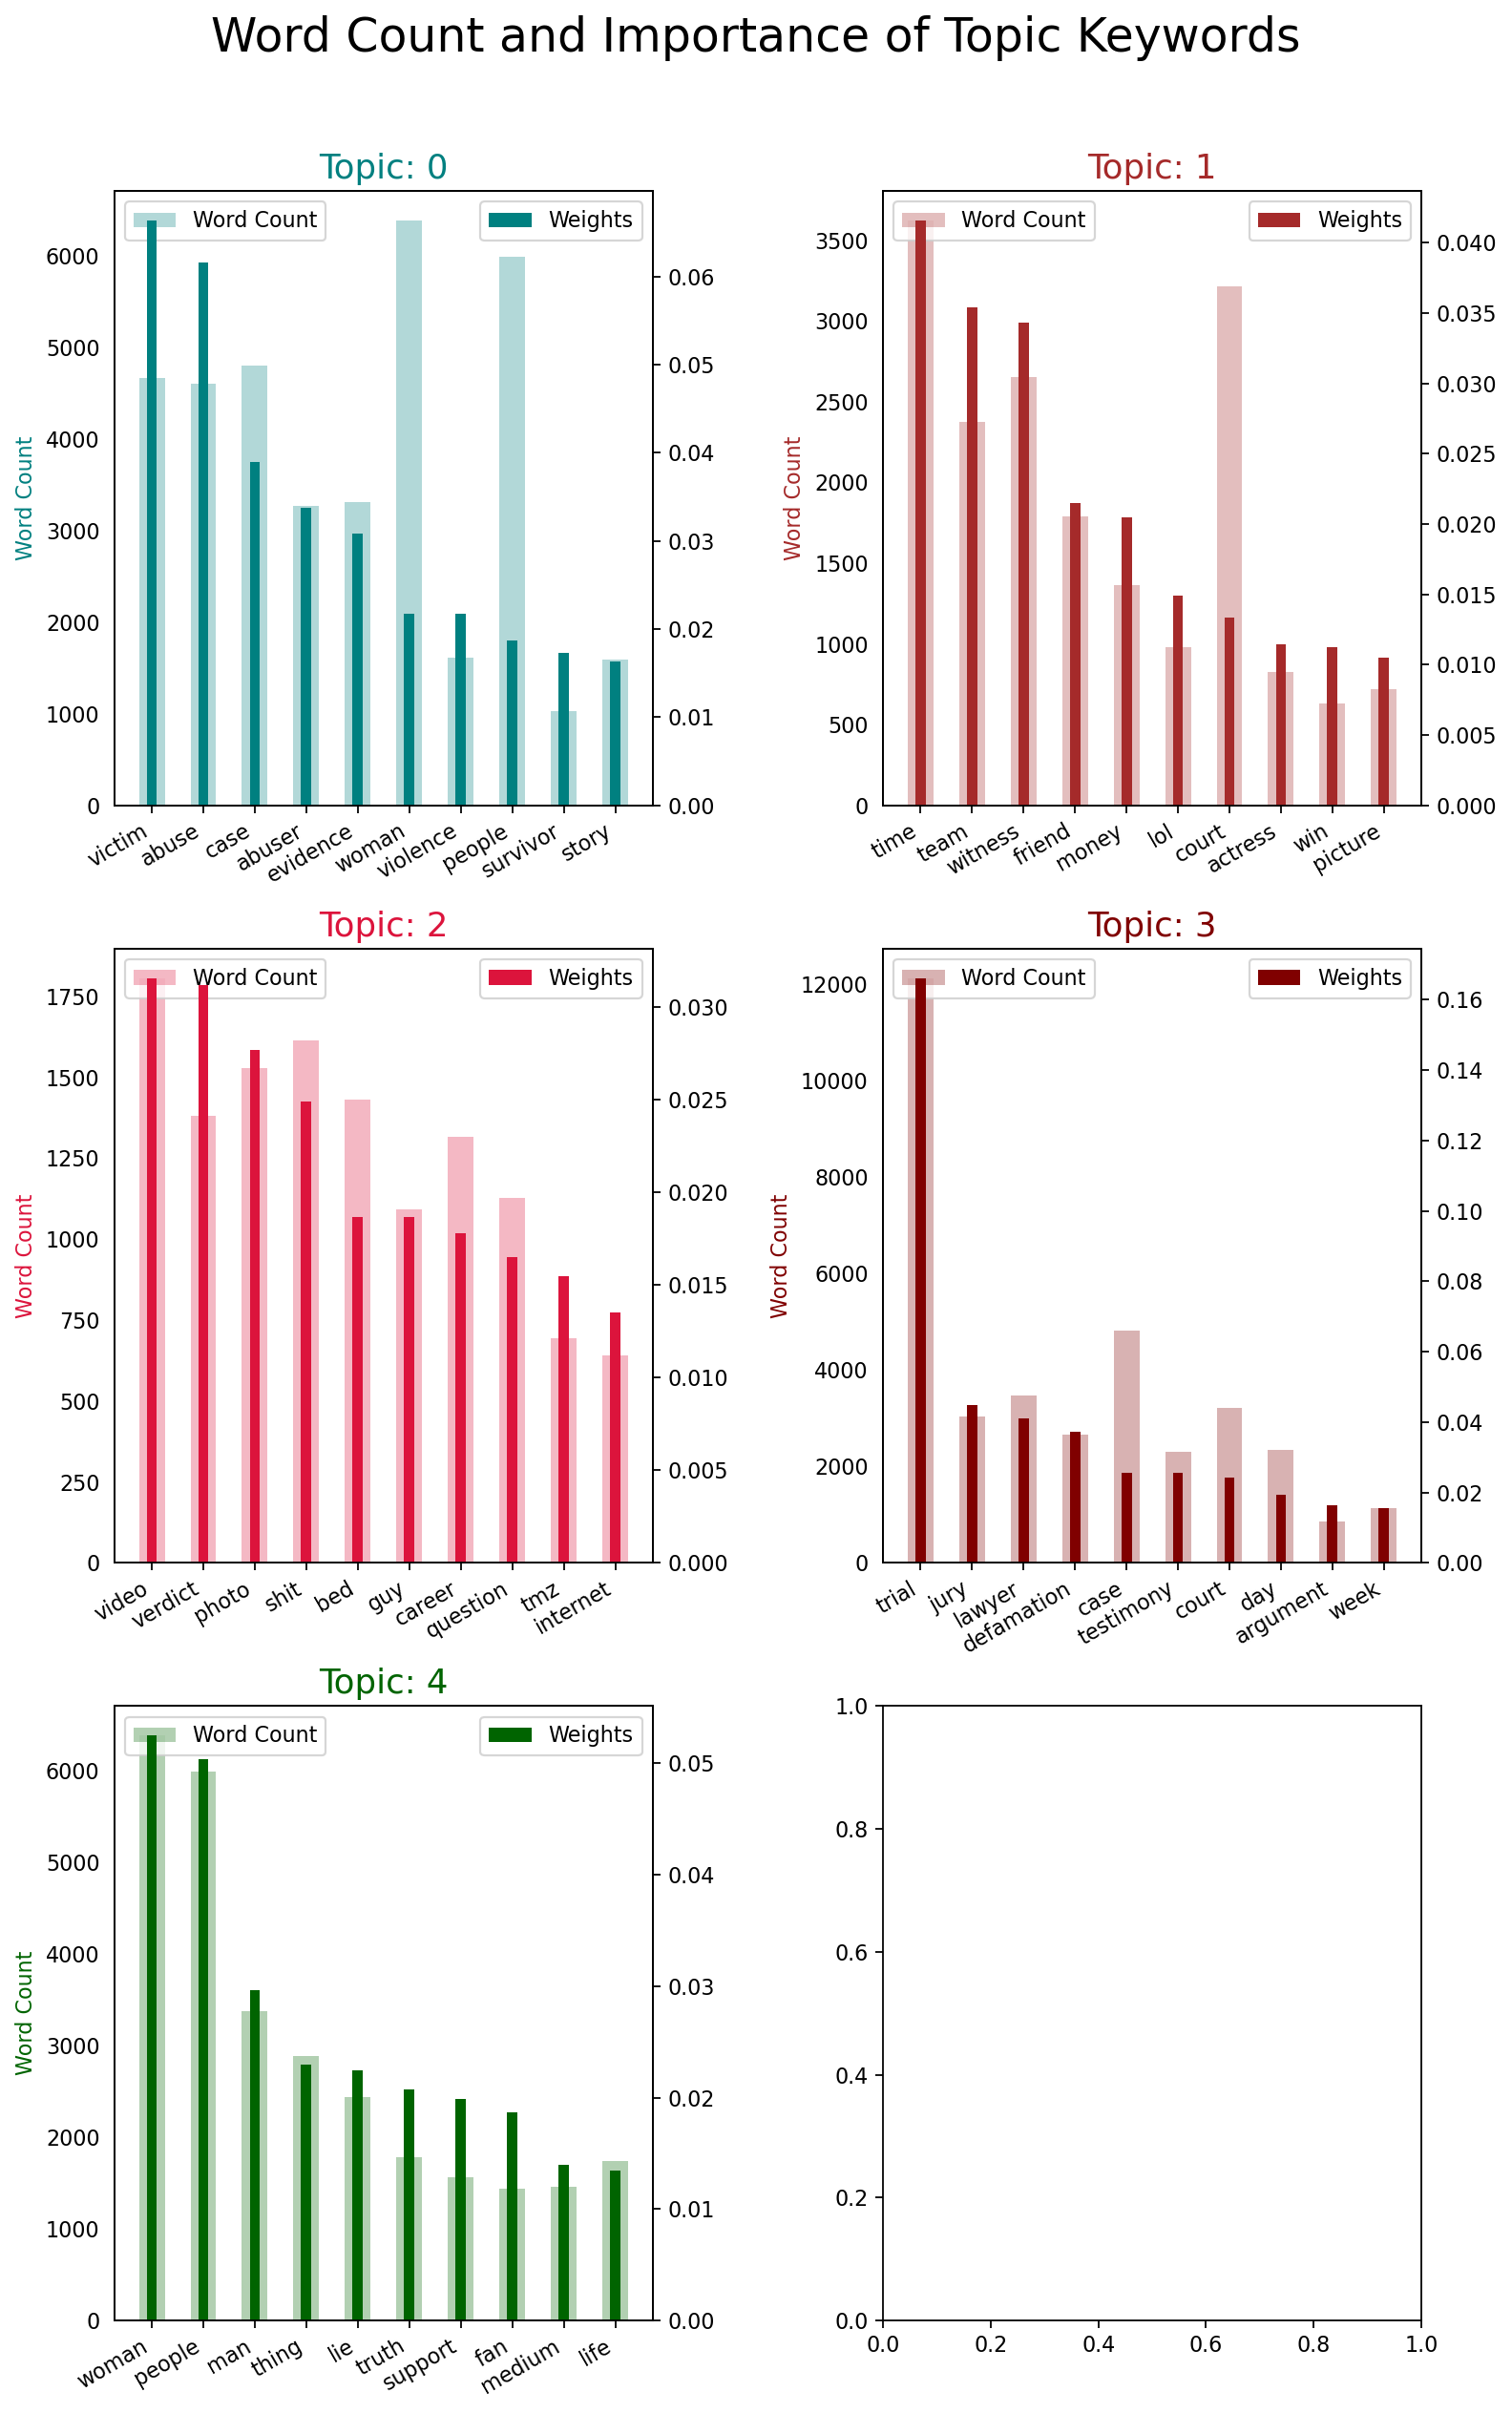

In [26]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
